
# PS2: Mini-batch SGD, CNN, and RNN

Advanced Learning 2025/6.



For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID:

~~~

~~~
STUDENT GIT LINK: https://github.com/Daniel210198/Adv.-computational-learning-and-data-analysis-course/tree/main
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS2_CNN_RNN_2025_ID.html`   




---


Imports:

In [ ]:
import numpy as np # You are allowed to use  only numpy.
import time, sys, cProfile
import matplotlib.pyplot as plt

Please import the objects in `src.py` file into the workspace

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
your_drive_path_to_src_file = "/content/drive/MyDrive/deep_learning_course/ex2"
sys.path.append(your_drive_path_to_src_file)


In [ ]:
from  src import *

Note that now all of the network's objects from PS1 are loaded into the workspace.

Alternatively, you can upload src.py in the files tab found on the left hand side if you are using colab.

---

### 0. Loading data

As in PS1, you will evaluate your home-made network on the `mnist` dataset.   
The MNIST dataset is a large dataset of handwritten digits that is commonly used for training various image and vision models.  



In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

---

## PS2 Part 1: Mini-batch SGD



**Welcome back**.   






Mini-batch Stochastic Gradient Descent (Mini-batch SGD) is an optimization algorithm used to train machine learning models, particularly neural networks. It strikes a balance between two other methods:

    Batch Gradient Descent – Uses the entire dataset to compute gradients and update the model parameters.
        ✅ Accurate gradients
        ❌ Slow and memory-intensive for large datasets

    Stochastic Gradient Descent (SGD) – Uses a single data point to compute gradients for each update.
        ✅ Fast and efficient
        ❌ Noisy updates, which can lead to instability

  
**Mini-batch SGD**.

Mini-batch SGD computes gradients and updates the model parameters using small, randomly selected batches of data (typically 32, 64, or 128 samples).

    ✅ Faster than batch gradient descent
    ✅ Less noisy than pure SGD
    ✅ Efficient use of memory
    ✅ Enables vectorization for faster computation on GPUs

**How it Works**.

    Shuffle the dataset to avoid bias.

    Divide the data into small batches (e.g., 64 samples per batch).

    For each epoch, iterate through the mini-batches:
        Perform forward pass to calculate predictions.
        Compute the loss for the mini-batch.
        Perform backpropagation to compute gradients.
        Update model parameters using the gradients.

    Repeat until the model converges.

**Algorithm**

For each mini-batch $B={x_1,x_2,...,x_m}B={x_1​,x_2​,...,x_m​}$ of size $m$, update the weights $w$ as:    

$$
w=w−η⋅\frac{1}{m}∑_{i=1}^m ∇L(w,x_i)
$$

Where:   
*  $η$ = learning rate.
* $∇L(w,x_i)$ = gradient of the loss for sample $x_i$.   

Advantages

    Efficient and scalable – Works well with large datasets.
    Smooth convergence – Less noisy than SGD but faster than full batch training.
    Parallelization – Batches can be processed in parallel on GPUs.

Disadvantages

    Choosing batch size can affect performance. Small batches lead to noise, large batches consume more memory.
    Convergence may be slower than batch gradient descent for some problems.


### Mini-batch Questions.
**P1Q1**:  

Please answer the following questions providing statistical justifications and mathematical formulas when needed.

**P1Q1a**: Explain how the mini-batch size impacts convergence, model performance, and computational efficiency.



 **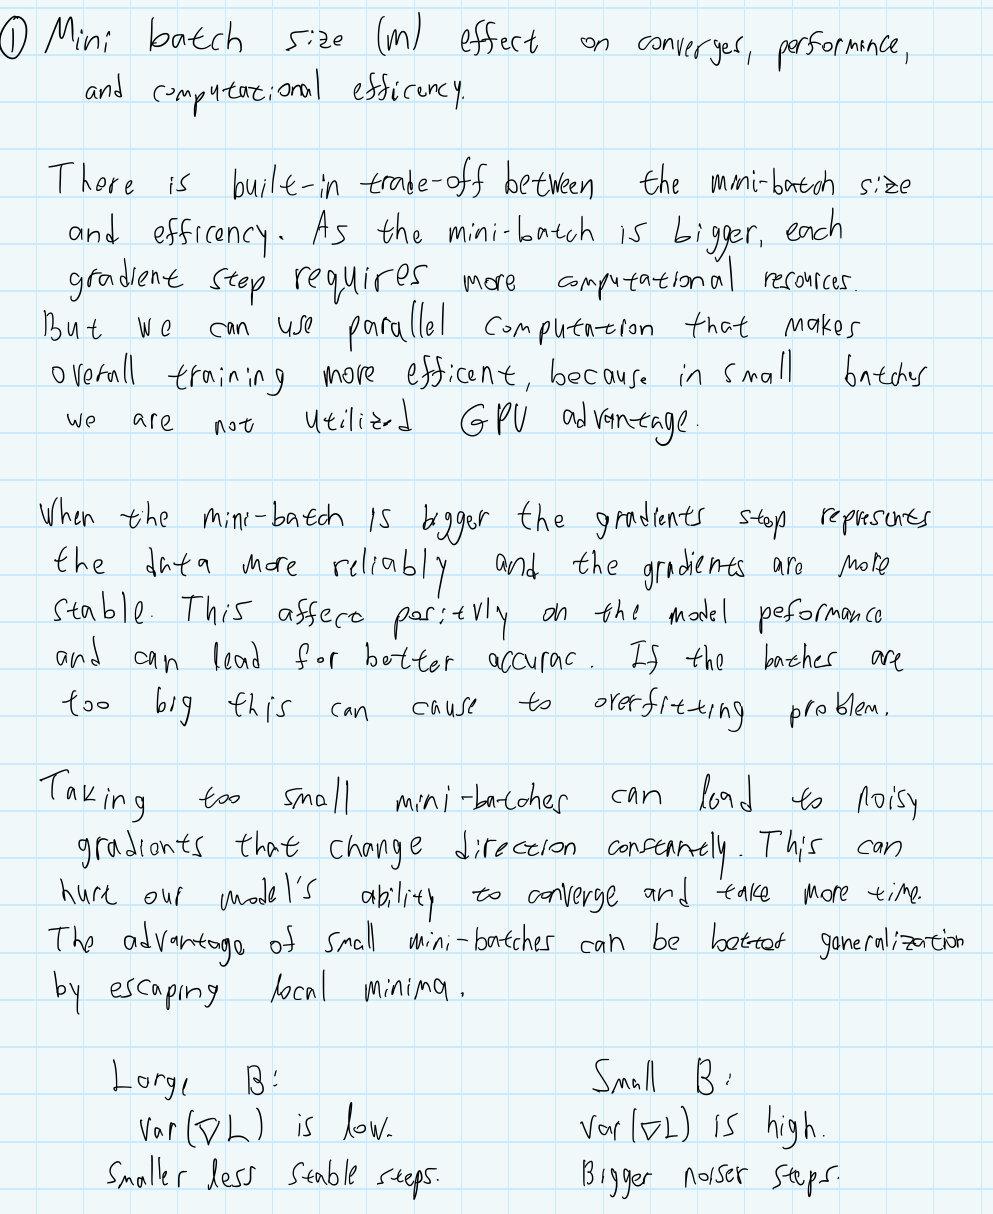

**P1Q1b:**   
Why does mini-batch SGD require a learning rate schedule, and what are the common scheduling strategies?



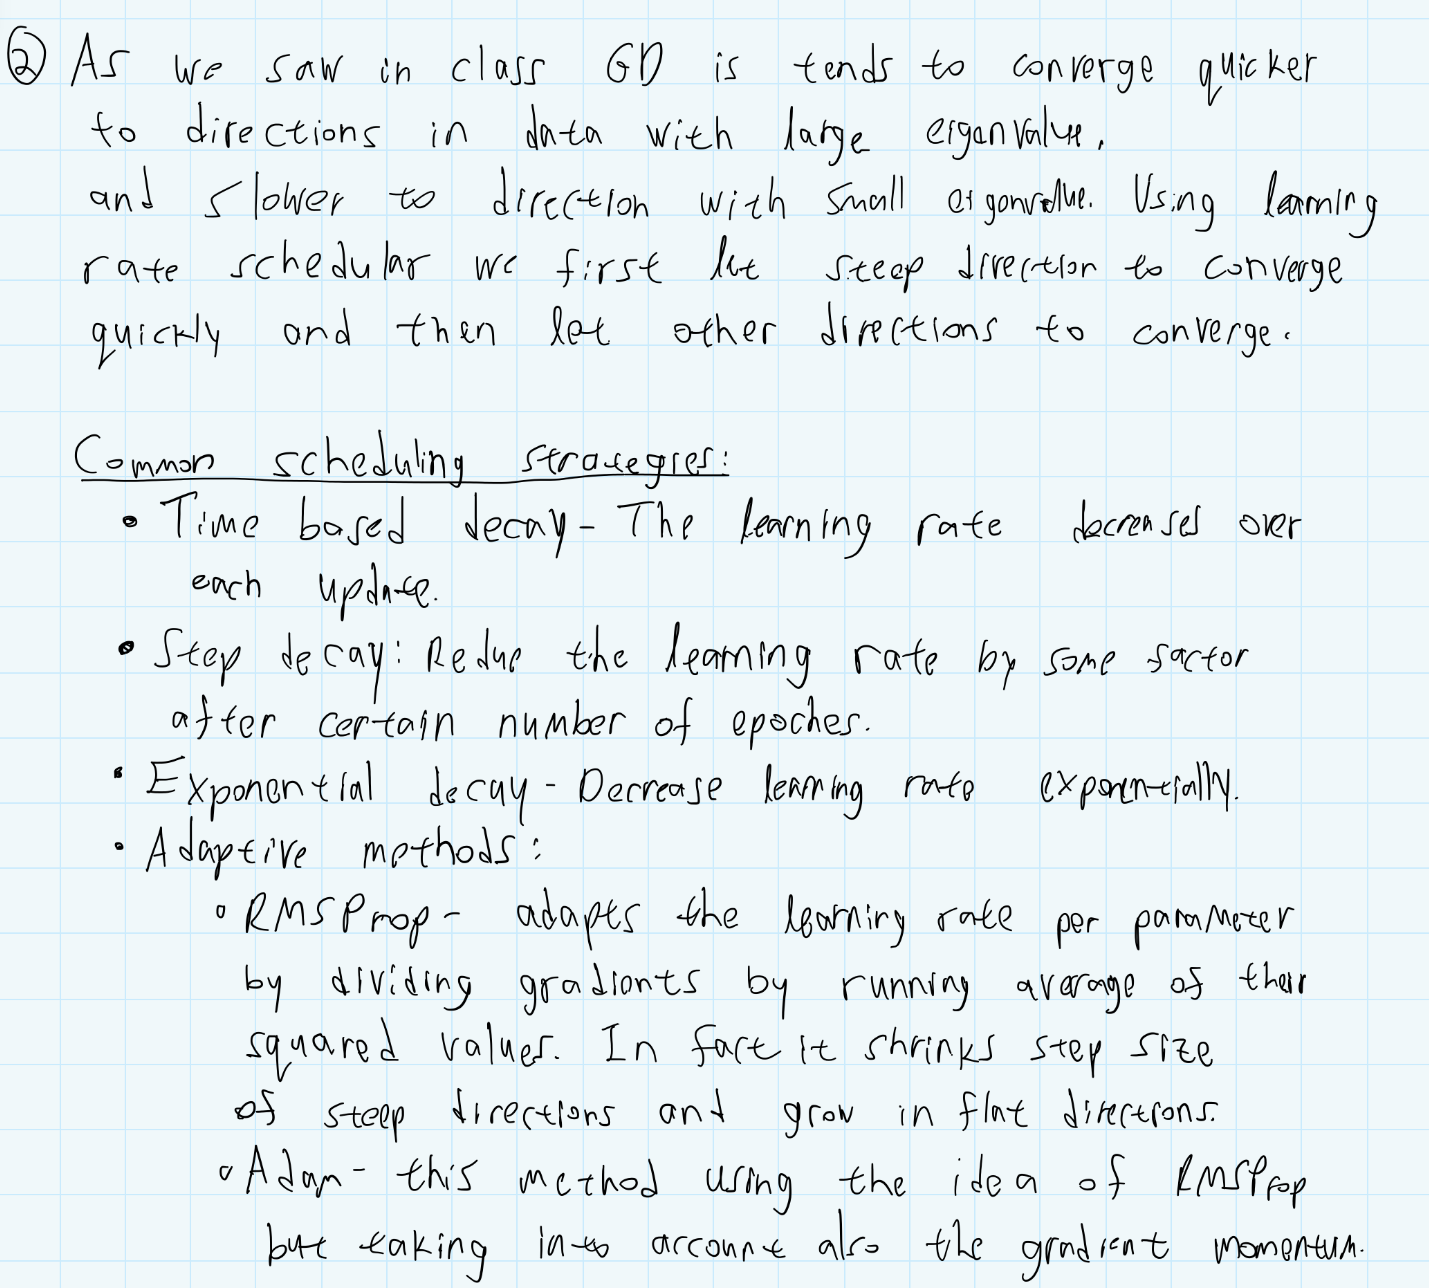

**P1Q1c**: What role does batch normalization play in mini-batch SGD, and why is it essential for deep neural networks?



Batch normalization is a technique designed to reduce the internal covariate shift problem in deep neural networks.
Internal covariate shift refers to the fact that, during training, each layer’s input distribution keeps changing because the previous layers weights are updated. As a result, deeper layers must constantly re-adapt and learn new statistics (new means and variances), which slows down training and makes optimization with mini-batch SGD unstable.

Batch normalization fixes this by normalizing the activations within each mini-batch: subtracting the batch mean, dividing by the batch standard deviation, and adding a small epsilon for numerical stability (avoid deviation by 0). This keeps the activation distribution stable throughout training, which improves gradient flow, allows higher learning rates, and significantly speeds up convergence.

Because deeper networks amplify distribution shifts, batch normalization becomes essential for training modern deep architectures efficiently and reliably.

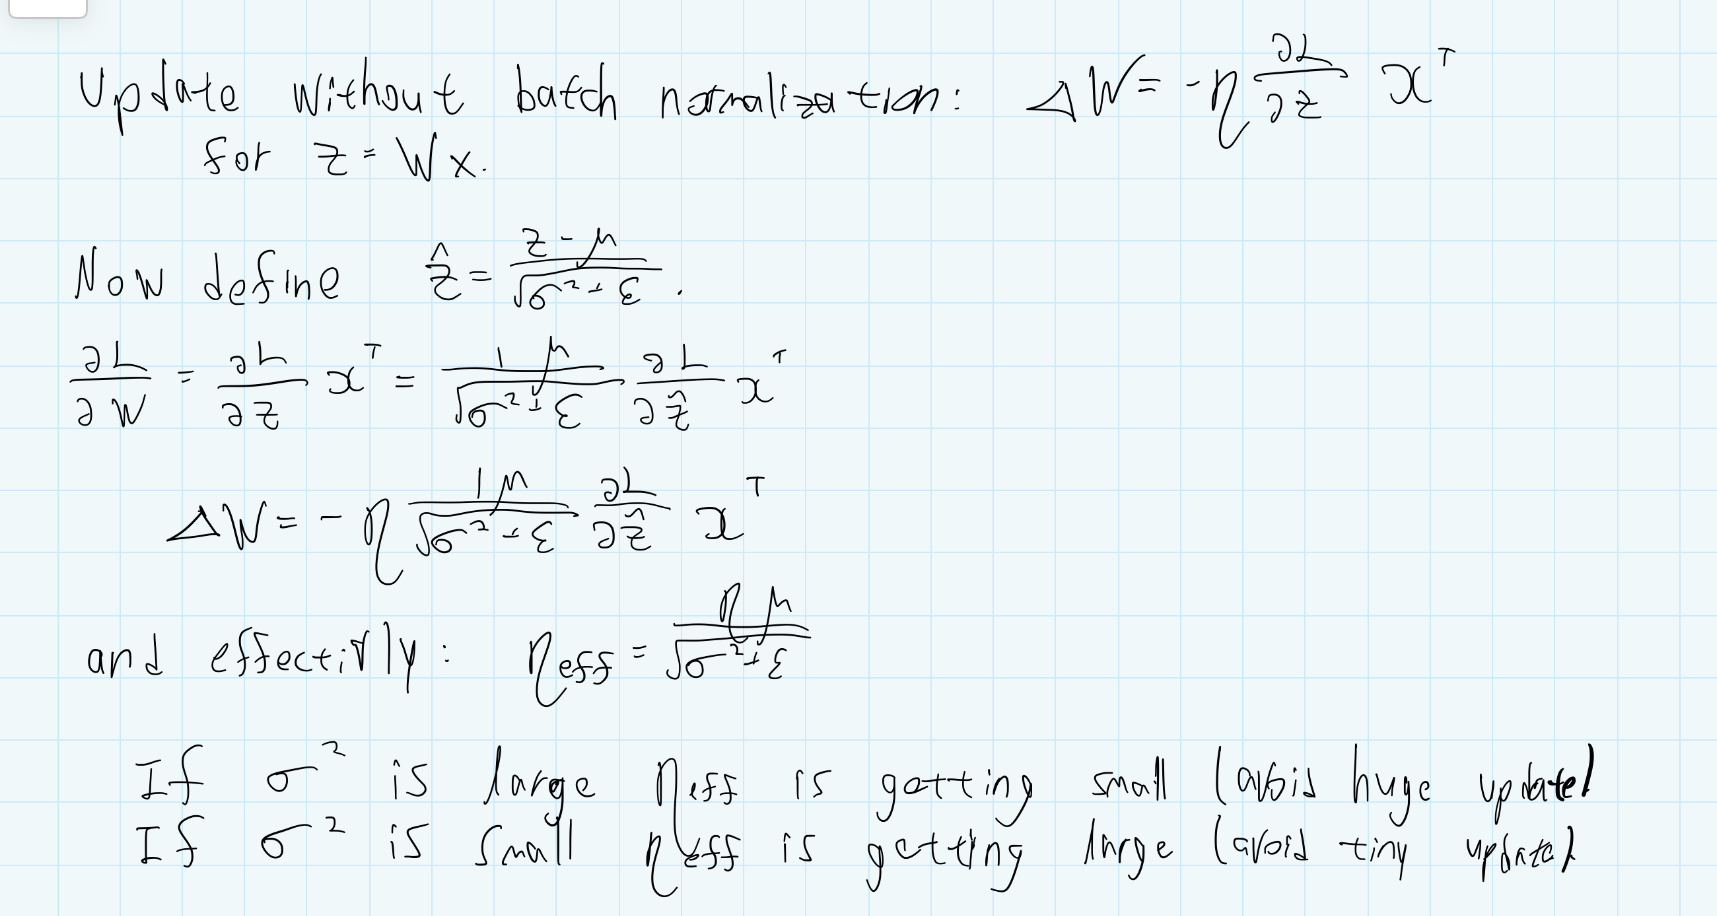

**P1Q1d**: How does mini-batch SGD differ in performance compared to full-batch gradient descent when dealing with non-convex optimization problems?


In mini-batch SGD the gradient steps are more noisey compare to full-batch GD. Non-convex optimization problems are characterized by that they have multy local minimas make the optimization harder and non trivial. By injecting noise to the gradient steps we encourage the model to escape from sharp local minimas and explore better regions of the loss surface.

**P1Q1e**: How does mini-batch SGD perform when training on imbalanced datasets, and what strategies can mitigate its challenges?



An imbalanced dataset occurs when the number of training examples is very different across classes, with some classes having many more samples than others. This causes the features of the minority classes to be learned poorly, leading to weak prediction performance for those under-represented classes.

When using mini-batch SGD, the imbalance problem becomes worse because many mini-batches may contain no examples from the minority classes. As a result, the gradients for those classes are not updated frequently, so the model does not learn their features well. This leads to lower accuracy for minority classes and a model that effectively fits only the majority classes.

Main strategies to deal with imbalance problem:

* Over/Under sampling - oversample the minority class or undersample the majority class so the dataset becomes more balanced.

* Data augmentation - create new minority class samples with transformations (rotation, cropping, color changes, noise, etc.) to increase their variety without simple duplication.

* Class-weighted loss - assign a higher loss weight to minority classes so the model “cares more” about their errors.

* Batch-balancing strategies - force each mini-batch to contain a balanced number of samples per class so gradients update all classes regularly.

**P1Q1f**: Explain why larger mini-batch sizes are preferred during inference but not necessarily during training.


During training, we want the optimizer to learn from all directions in the data. If the mini-batch is too large, the gradient becomes dominated by the “main” directions and loses the useful noise that helps explore weaker or less frequent directions. This can lead to poorer generalization and slower convergence.

During inference, there is no learning, so we do not need gradients or exploration of weaker directions. The goal is only to run efficient forward passes, and large batches allow us to fully use hardware parallelization so we will prefer larger bacthes.

### Applying mini-batch SGD

Preparing the data:

In [ ]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0],1 , 28*28)

x_train = x_train.astype('float32')
x_train /= 255 #Nomalizing, We don’t subtract the mean because MNIST is simple black and white images
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

P1Q2a:  

Add a new function to the class `MyNetwork` named `fit_mini_batch`. This function should be similar to `fit`, just with a mini-batch SGD implementation. You can also make other code changes to the scripts in `src` if you think they are needed. In addition, add a suitable learning rate scheduler of your choice.   


YOU SHOULD (a) add the missing script to the src code, and (b) make a copy of the function  below for review:

In [ ]:
def fit_mini_batch(self, x_train, y_train, batch_size, epochs, learning_rate):
    x_len = len(x_train)
    for epoch in range(epochs):
        indices = [i for i in range(len(x_train))]
        np.random.shuffle(indices)
        for i in range(0, x_len, batch_size):
            batch_indices = indices[i : i + batch_size]
            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]
            loss = 0
            for img_ind in range(len(x_batch)):
                output = x_batch[img_ind]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                loss += self.loss(y_batch[img_ind], output)
                grad = self.loss_grad(y_batch[img_ind], output)
                for layer in reversed(self.layers):
                    grad = layer.backward_propagation(grad, learning_rate)
            loss /= len(x_batch)
        print(f'The loaa in epoch{epoch+1} from {epochs} epoches is loss ')
        print("Epoch %d/%d - Loss: %f" % (epoch + 1, epochs, loss))



    Test the two networks below to compare the differences between GD and mini-batch SGD:

In [ ]:
#### GD implementaiton ####

# Network Architecture
#from src import *

netGD = MyNetwork()


netGD.add(Affine_Layer(28*28, 128))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(128, 64))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(64, 10))
netGD.add(ActivationLayer(tanh, tanh_grad))

netGD.use_loss(mse, mse_grad)


epoch_num = 10
lr = 0.05
t1 = time.time()
netGD.fit(x_train[:10000], y_train[:10000], epochs=epoch_num, learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training on 10,000 samples:
Training epoch 1/10   error=0.041373
Training epoch 2/10   error=0.024190
Training epoch 3/10   error=0.018872
Training epoch 4/10   error=0.015901
Training epoch 5/10   error=0.013898
Training epoch 6/10   error=0.012423
Training epoch 7/10   error=0.011258
Training epoch 8/10   error=0.010293
Training epoch 9/10   error=0.009466
Training epoch 10/10   error=0.008740
Total process time: 69.883


In [ ]:
output_GD = netGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0121, Accuracy: 9341/10000 (93%)



I added this learning rate schedular function to src:



```
 def lr_schedular(self, learning_rate, epoch):
        return learning_rate * (0.7 ** epoch)
```

This scheduler applies exponential learning-rate decay, multiplying the learning rate by 0.7 each epoch so it steadily decreases over time.

In [ ]:
#### mini-batch SGD implementaiton ####

# Network Architecture
netMiniGD = MyNetwork()


netMiniGD.add(Affine_Layer(28*28, 128))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(128, 64))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(64, 10))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))

netMiniGD.use_loss(mse, mse_grad)
learning_rate = 0.05
lr_sched = netMiniGD.lr_schedular

epoch_num = 10
t2 = time.time()
netMiniGD.fit_mini_batch(x_train[:10000], y_train[:10000], batch_size=128, epochs=epoch_num, learning_rate=learning_rate, lr_scheduler=lr_sched)
print(f"Total process time: {round(time.time() - t2,3)}")


Epoch 1/10 - Loss: 0.035394 - LR: 0.050000
Epoch 2/10 - Loss: 0.019802 - LR: 0.045000
Epoch 3/10 - Loss: 0.009391 - LR: 0.040500
Epoch 4/10 - Loss: 0.008895 - LR: 0.036450
Epoch 5/10 - Loss: 0.018642 - LR: 0.032805
Epoch 6/10 - Loss: 0.006312 - LR: 0.029525
Epoch 7/10 - Loss: 0.010786 - LR: 0.026572
Epoch 8/10 - Loss: 0.007323 - LR: 0.023915
Epoch 9/10 - Loss: 0.005792 - LR: 0.021523
Epoch 10/10 - Loss: 0.006754 - LR: 0.019371
Total process time: 72.732


In [ ]:
outputMiniGSD = netMiniGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0122, Accuracy: 9378/10000 (94%)



P1Q2b:   
Please answer the following:
* Which implementation was faster?
* with lower training error?
* with better test accuracy?    

and explain how these results fit your answers in Q1A.

The SGD implementation was faster than the mini-batch SGD. This makes sense because in SGD we process one sample at a time, without creating batches, so the loop is simpler and has less overhead. In mini-batch SGD, we need to shuffle indices, slice batches, and process multiple samples per update, which adds extra looping and array operations, so the running time becomes a bit longer.

On a GPU, mini-batch SGD would be much faster because GPUs execute large batch operations in parallel, while pure SGD cannot take advantage of parallelism.

The training loss was a little bit smaller in SGD (0.0121) than in mini-batch SGD (0.0122), but the accuracy was higher for mini-batch SGD (94% vs. 93%). This makes sense because SGD uses very noisy updates, so it can overfit slightly to the training samples and reach a lower training loss, but this does not always translate to better generalization. mini-batch SGD uses smoother gradient estimates, which can act as a regularizer and usually leads to better test accuracy even if the training loss is slightly higher. This accuratly fit to my answers in Q1A that describes the dynamics in mini-batch SGD.

## PS2 Part 2: CNN



A Convolutional Neural Network (CNN) is a type of a deep neural network that can perform well at image recognition and analysis tasks.


> In this problem set we will add CNN compatibility to our numpy-based neural network from PS 1.

The main components needed to implement a CNN architecture:  

**Convolution layer:** In the convolutional layers, filters are applied to the image to identify patterns and features. Imagine a sliding window that moves across the image, detecting edges, shapes, and other building blocks.  

**Pooling layer:** Pooling layers downsample the data, reducing its complexity and computational cost. This helps prevent overfitting, where the model memorizes training data instead of learning generalizable patterns.  

**Reshape layer:**
Reshaping the output of the convolution and pooling layers into the fully connected layer.   


A USEFUL HINT:

*Keeping account of the input and output shapes along the CNN network is crucial for the model to work as intended*



Useful resource:  
* [CS231](https://cs231n.github.io/convolutional-networks/).
* [Convolutional Neural Network From Scratch](https://www.kaggle.com/code/lusfernandotorres/convolutional-neural-network-from-scratch).
* [CNN with PyTorch](https://www.kaggle.com/code/sdelecourt/cnn-with-pytorch-for-mnist)

#### Data transformations





(Here I added a reshape that I originally intended for you to apply at model time).

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],1,
                          x_train.shape[1],x_train.shape[2])
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],1,
                          y_train.shape[1])

# same for test data : 10000 samples
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0],1,
                          x_test.shape[1],x_test.shape[2])
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],1,
                          y_test.shape[1])

In [ ]:
print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)


x_train shape (60000, 1, 28, 28)
x_test shape (10000, 1, 28, 28)
y_train shape (60000, 1, 10)
y_test shape (10000, 1, 10)


Unlike the multilayer perceptron (MLP) architecture, the input to the convolution net is not flattened. In our case, the size of a single `MNIST` datapoint is (1,28,28). The first dimension is the number of channels (e.g. RGB  for color images). During training the inputs and outputs often  change shape as they pass through the convolution, pooling, and the other layers of the network.

---

### A. Convolution Layer

Here you are asked to implement a basic Convolution layer with the following components:



1.   Layer initialization - initialize the layer's filters using Normalized Xavier/Hu weights
2.   A generator function that yields all the available sliding windows in the input image.
3.   Forward propogation for the convolution layer
4.   Backward propogation for the convolution layer

[CS231](https://cs231n.github.io/convolutional-networks/#conv) provides a great overview both mathematically and visually,   
and [CS230](https://cs230.stanford.edu/section/4/) provides a good overview about Xavier initialization.




P2Q1a:  (10pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.    
You can deviate slightly from the recommended structure below, but please remain true to the class structure and compatibility with the rest of the network classes and functions. The idea here is to write YOUR OWN version of CNN, so please try not to google the answers.





In [ ]:
### MISSING: SOLUTION REQUIRED IN THIS CODE BLOCK

class Convolution:
    # convolution layer using num_filters x num_filters filters.
    # size is the length/width of the filter window with shape (size x size)
    # In this simple implementation, there is no padding.

    def __init__(self, num_filters=3, size=3, activation=None):
        self.stride = 1 # for simplicity, we keep the stride=1.
        self.size = size
        self.activation = activation
        self.num_filters = num_filters
        self.last_input = None


        # Initialize the Convolution layer filters
        ## SOLUTION REQUIRED!!
        fan_in = 1 * self.size * self.size # num_channels * filter hieght * filter width
        limit = np.sqrt(1.0/fan_in)
        self.filters = np.random.randn(self.num_filters, 1, self.size, self.size) * limit


    def patch_generator(self, image):
        # This generator (using yield) returns all the  possible patches of  the input image
        # of shape  (h,w)  for each channel c, together with the relevant y,x coordinates of the patch.
        # input_data/image must be shaped as (c,y,x), where c is the channel/filter
        ch,h,w = image.shape

        for y in range(0,h-self.size+1):
            for x in range(0,w-self.size+1,self.stride):
                patch = image[:, y: y + self.size , x:x + self.size]
                yield patch, y, x


    def forward_propagation(self, image):
        # Calculate the convolution forward pass using the filters together with a
        # user specified activation function.

        # If this is the first convolution layer, the input image is size (h,w) and must be expanded to (c,h,w).
        if len(image.shape)==2:
            image = np.expand_dims(image, axis=0)
        # keep track of last input for later backward propagation
        self.last_input = image
        # Initializing the output array:
        ## SOLUTION REQUIRED!!
        input_dimension = image.shape

        output_dimension = (
            self.num_filters,
            image.shape[1] - self.size + 1,  # h_out
            image.shape[2] - self.size + 1   # w_out
        )

        output = np.zeros(output_dimension)


        # forward pass on each filter
        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(image):
                ## SOLUTION REQUIRED!!
                output[f, y, x] = np.sum(self.filters[f] * patch) #pay attention that concultion is element wise and not matrix multiplication


        # Applying activation function (this is a small cheat/simplification
        #  because the activation should be a separate layer in itself.  )
        if self.activation is not None:
            output = self.activation.forward_propagation(output)
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the SGD in-gradients of the filters and the layer.
        # Update only the filters gradients.

        # back propagate through activation (again, a bit of a cheat)
        if self.activation is not None:
            grad_out = self.activation.backward_propagation(grad_out,learning_rate)

        ## SOLUTION REQUIRED!!
        grad_in = np.zeros_like(self.last_input)  #loss gradient of the input
        grad_filter = np.zeros_like(self.filters) # loss gradient of filter


        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(self.last_input):
                ## SOLUTION REQUIRED!!
                grad_filter[f] += grad_out[f, y, x] * patch # calculate the gradient of the filter
                grad_in[:, y:y + self.size, x:x + self.size] += grad_out[f, y, x] * self.filters[f]


        ## SOLUTION REQUIRED!!
        self.filters -= learning_rate * grad_filter# update filters using SGD

        return grad_in    # return the loss gradient for this layer's inputs


### B. Max-pooling Layer

As with the convolution layer, here you are asked to implement a basic max-pooling layer with the following components:


1.   A generator function that yields all the available sliding windows in the input image. You can reuse the generator from (1).
2.   Forward propogation for the max-pooling layer
3.   Backward propogation for the max-pooling layer

The pooling layer is responsible for reducing the dimensionality of the input. As with the convolution layer, the pooling layer slides a filter across the entire image input to calculate the output. Note that this layer does not have any weights.  As the filter slides through the input image, it selects the pixel with the maximum value to populate the output array.

P2Q1b: (10pts).       

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [ ]:
### MISSING CODE IN THIS BLOCK

class MaxPool:
    def __init__(self,  size=2):
        # max pooling layer

        self.last_input = None
        self.stride = 1
        self.size = size

    def patch_generator(self, image):
      # This generator (using yield) returns all the  possible patches of  the input image
      # of shape  (h,w)  for each channel c, together with the relevant y,x coordinates of the patch.
      # input_data/image must be shaped as (c,y,x), where c is the channel/filter
      ch,h,w = image.shape

      for y in range(0,h-self.size+1):
        for x in range(0,w-self.size+1,self.stride):
          patch = image[:, y: y + self.size , x:x + self.size]
          yield patch, y, x

    def forward_propagation(self, image):
        # keep track of last input for later backward propagation
        self.last_input = image

        # compute output dimensions after the max pooling
        num_channels, h_prev, w_prev = image.shape
        ## SOLUTION REQUIRED!!
        h_new = h_prev - self.size + 1
        w_new = w_prev - self.size + 1


        # hold the values of the max pooling
        output = np.zeros((num_channels, h_new, w_new))

        # Calculate the max pool on all the image patches using the generator:
        # CODE MISSING
        for patch, y, x in self.patch_generator(image):
            output[:, y, x] = np.max(patch, axis=(1,2))  ## SOLUTION REQUIRED!!
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the gradients of the last input image
        num_channels, orig_dim, *_ = self.last_input.shape
        grad_in = np.zeros_like(self.last_input)

        # Using the generator, go over all the channels and calcualte the max-pooling input gradients
        # for c in range(num_channels):
        for patch, y, x in self.patch_generator(self.last_input):
            c, dy, dx = np.unravel_index(np.nanargmax(patch), patch.shape)
            ## SOLUTION REQUIRED!!
            grad_in[c, y + dy, x + dx] += grad_out[c, y, x]

        return grad_in


### C. Reshape Layer

A reshape layer in a neural network is a transformation layer that doesn't perform any computations itself (no weights).   
Its purpose is to simply change the dimensionality (shape) of the data flowing through the network.

Here's how reshape layers work:

You define a target shape for the output of the reshape layer.   
This target shape specifies the number of elements along each dimension (width, height, channels, etc.) for the new data format.

P2Q1c:  (5pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [ ]:
### MISSING CODE IN THIS BLOCK ####
class Reshape:
    def __init__(self,input_shape,output_shape):
        self.input_shape=input_shape
        self.output_shape=output_shape
    def forward_propagation(self,input_data):
        ## SOLUTION REQUIRED!!
        self.last_input_shape = input_data.shape
        return np.reshape(input_data, self.output_shape)

    def backward_propagation(self,output_gradient,learning_rate):
        # you can ignore the learning_rate
        ## SOLUTION REQUIRED!!
        return np.reshape(output_gradient, self.last_input_shape)


### Testing Your Neural Network

### Defining our main neural network architecture

Define your CNN network's architecture:

* A convolution layer with some filters `(f)` and a window size of `(w x w)`, with a `tanh` activation function.
* A max pooling layer of a window size of `(p x p)`.  
* First affine layer that takes your input and outputs 128 nodes
* `tanh` activation layer following the first affine layer
* Second affine layer that takes the first layer's input and outputs 64 nodes
* `tanh` activation layer following the second affine layer
* Third affine layer that takes your second layer's input and outputs nodes in the size of the Y labels.
* `tanh` activation layer following the last affine layer


You can compute the shapes of the convolution and max-pool layers' outputs  as a function of the input shape, the convolution sliding window size, and the number of filters for applied. ( the stride and padding are usually also used to calculate the output shapes, but in this simple implementation we set the stride to 1 with zero padding.).

P2Q2a: (5pts).        
Calculate the input and output shapes of each layer in the network below, up until the first affine layer (including).  (mathematically) explain your answer.  

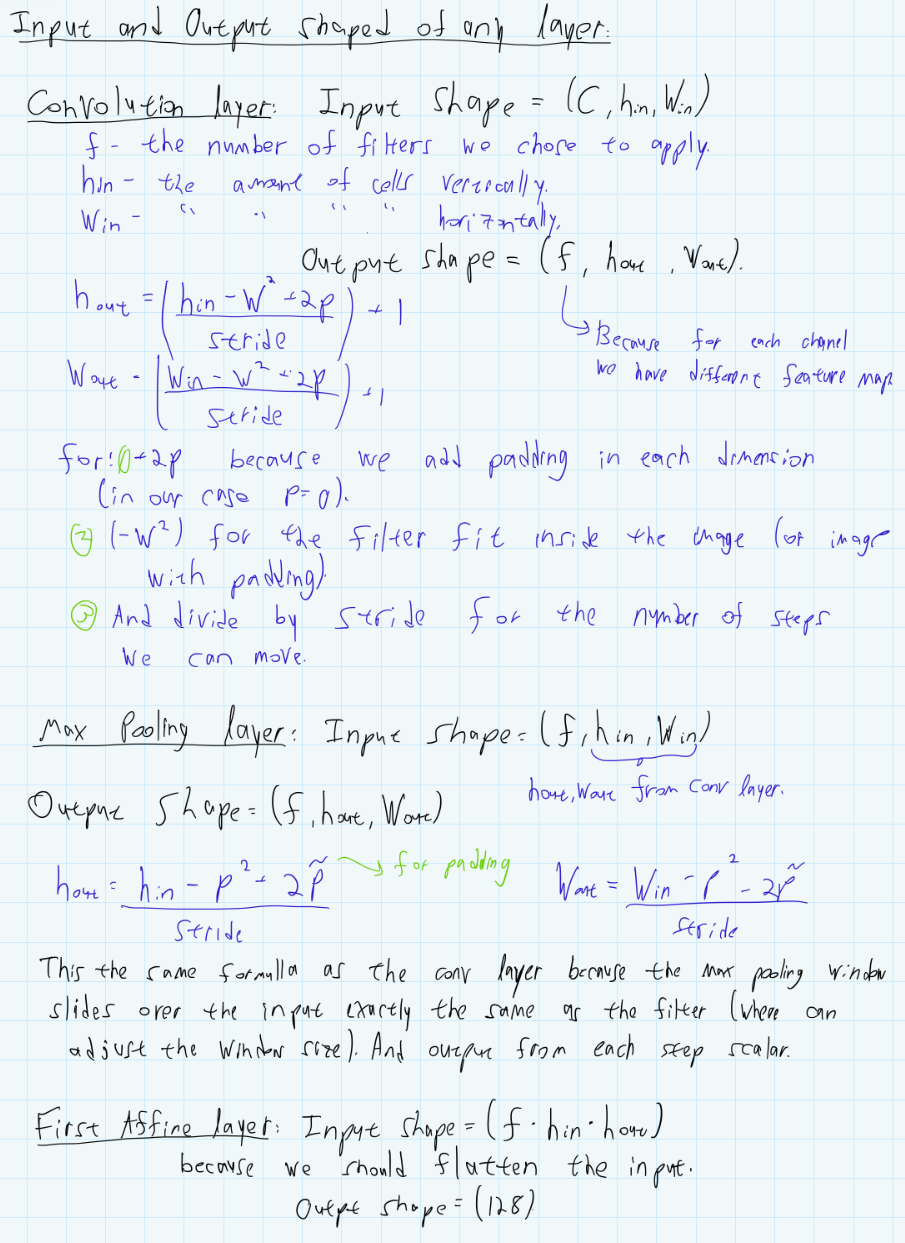

P2Q2b:  (5pts).   

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the network architecture works properly.  





In [ ]:
#### SOLUTION REQUIRED IN THIS BLOCK (in  reshape parameters) ####

# Network Architecture
CNNnet = MyNetwork()
num_classes = 10


# Reshape sizes:
## SOLUTION REQUIRED!!

num_filters = 12
h_in = x_train.shape[2]   # 28
w_in = x_train.shape[3]   # 28

# Conv output
f = 3                     # conv filter size
h_conv = h_in - f + 1     # 28 - 3 + 1 = 26
w_conv = w_in - f + 1     # 26

# MaxPool output
p = 3                     # pool size
h_pool = h_conv - p + 1   # 26 - 3 + 1 = 24
w_pool = w_conv - p + 1   # 24

c = 12
y_new = h_pool
x_new = w_pool


# Adding convolution and max-pool layers:
CNNnet.add(Convolution(num_filters=12, size=3,
                    activation=ActivationLayer(relu, relu_grad))) #
CNNnet.add(MaxPool(size=3))

# Reshaping for first affine layer:
CNNnet.add(Reshape((c, y_new, x_new), (1, c*y_new*x_new)))

# Adding affine layers and activation functions:
CNNnet.add(Affine_Layer(c*y_new*x_new, 128))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(128, 64))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(64, num_classes))
CNNnet.add(ActivationLayer(tanh, tanh_grad))

# CNNnet.add(ActivationLayer(relu, relu_grad))
# CNNnet.add(ActivationLayer(tanh, tanh_grad))
# CNNnet.add(ActivationLayer(sigmoid, sigmoid_grad))

### Training!

There is no need to train the model on the entire dataset (you'l see why now...). Try to prove that your network works as expected by showing that your error decreases dramatically even on a small sample (say, around 1k).

In [ ]:
# While developing, it is recommended to train your model on a subset of the data... / or low epochs.
# Training will be pretty slow if we update at each iteration on 60000 samples...]
CNNnet.use_loss(mse, mse_grad)
epoch_num = 20 #20
lr = 0.1
t1 = time.time()
CNNnet.fit(x_train[:1000], y_train[:1000], epochs=epoch_num,
           learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")




Training on 1,000 samples:
Training epoch 1/20   error=0.082126
Training epoch 2/20   error=0.044970
Training epoch 3/20   error=0.033395
Training epoch 4/20   error=0.025872
Training epoch 5/20   error=0.020797
Training epoch 6/20   error=0.016999
Training epoch 7/20   error=0.014124
Training epoch 8/20   error=0.011928
Training epoch 9/20   error=0.010267
Training epoch 10/20   error=0.009010
Training epoch 11/20   error=0.007809
Training epoch 12/20   error=0.006835
Training epoch 13/20   error=0.006033
Training epoch 14/20   error=0.005374
Training epoch 15/20   error=0.004798
Training epoch 16/20   error=0.004291
Training epoch 17/20   error=0.003866
Training epoch 18/20   error=0.003480
Training epoch 19/20   error=0.003157
Training epoch 20/20   error=0.002856
Total process time: 4791.899


Hurray - if you got to this point, your CNN model works, but is EXTREMELY slow.   
Let's check why using a cProfiler:

In [ ]:
CNNnet.prof(x_train[:100], y_train[:100],epochs=4,learning_rate=lr)


Training on 100 samples:
Training epoch 1/4   error=0.002431
Training epoch 2/4   error=0.001866
Training epoch 3/4   error=0.001446
Training epoch 4/4   error=0.001224
         33613507 function calls (33613489 primitive calls) in 114.059 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
       16    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
      2/1    0.006    0.003   27.636   27.636 <string>:1(<module>)
       16    0.000    0.000    0.001    0.000 __init__.py:183(dumps)
      400    0.008    0.000    0.025    0.000 _methods.py:110(_mean)
   230400    0.195    0.000    1.115    0.000 _methods.py:58(_any)
      400    0.007    0.000    0.008    0.000 _methods.py:76(_count_reduce_items)
   230400    0.055    0.000    0.055    0.000 _nanfunctions_impl.py:574(_nanargmax_dispatcher)
   230400    2.313 

P2Q2c:  (5pts).     
Why do you think our CNN implementation is slow? Your answer should relate to the  approximate `O(n)` time/computational complexity .

Our CNN implementation is slow because many of its operations scale linearly with the size of the input sequence (n), but we repeat this linear work many times inside Python loops. For each convolution we slide a 3×3 window across the image, which is an O(n) operation, and we do this again for every filter, every pixel location, and again during backpropagation. Since all these O(n) steps are implemented in Python rather than vectorized NumPy, the total runtime becomes extremely large, making the model very slow.

A very good piece of evidence for this can be seen in the output of the cProfiler method. There we can see the number of times operations were executed. The function patch_generator was called over 6 million times. In this function we perform nested for-loops with a few simple operations, but when this happens millions of times it leads to a very long training period.

### Evaluation

Exciting! Now is the time to test your model.     


    May the gradients be always in your favor.

P2Q2b (cont'd):

**Try to limit the number of epochs and the size of the trained data, while still achieving an accuracy score of >85%.**

In [ ]:
output = CNNnet.predict(x_test[:500] ,y_test[:500] )


Test set: Avg. loss: 0.0241, Accuracy: 442/500 (88%)



### Benchmarking against PyTorch

How well your model performs against a similar-architecture PyTorch model?   
It is time to find out:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

**Prepare the data as tensors using PyTorch DataLoader:**

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# # training data : 60000 samples
# # reshape and normalize input data
# x_train = x_train.reshape(x_train.shape[0], 1, 28*28) not needed
x_train = x_train.astype('float32')
x_train /= 255
# # One-hot encoding of the output.
# # Currently a number in range [0,9]; Change into a vector of size 10
# # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# # same for test data : 10000 samples
# x_test = x_test.reshape(x_test.shape[0], 1, 28*28) not needed
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

In [ ]:
t_train =  TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train))
t_test =  TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
train_loader = torch.utils.data.DataLoader(dataset=t_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=t_test, batch_size=64, shuffle=False)

Define a `PyTorchCNN` class with an identical architecture you used in your home-made network.  
Hint: use `x = x.view()` to handle reshapes.

P2Q3a: (5pts).   

In [ ]:
#### SOLUTION REQUIRED  IN THIS BLOCK####

class PyTorchCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 12, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.Flatten(),
        nn.Linear(12 * 24 * 24, 128),
        nn.Tanh(),
        nn.Linear(128, 64),
        nn.Tanh(),
        nn.Linear(64, 10),
        nn.Tanh()
      )

  def forward(self, x):
    x = x.unsqueeze(1)
    return self.net(x)

In [ ]:

# Train the model
num_epochs = 10
pt_learning_rate = 0.01
pt_network = PyTorchCNN()
optimizer = torch.optim.Adam(pt_network.parameters(), lr=pt_learning_rate)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        # labels = labels.view(64,1,10)
        outputs = pt_network(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # A handy printout:
        if (i + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')




Epoch [1/10], Step [500/938], Loss: 0.0062
Epoch [2/10], Step [500/938], Loss: 0.0017
Epoch [3/10], Step [500/938], Loss: 0.0086
Epoch [4/10], Step [500/938], Loss: 0.0107
Epoch [5/10], Step [500/938], Loss: 0.0079
Epoch [6/10], Step [500/938], Loss: 0.0114
Epoch [7/10], Step [500/938], Loss: 0.0060
Epoch [8/10], Step [500/938], Loss: 0.0064
Epoch [9/10], Step [500/938], Loss: 0.0079
Epoch [10/10], Step [500/938], Loss: 0.0073


Evaluation:

In [ ]:
pt_network.eval()
test_losses = []
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = pt_network(data)
        test_loss += criterion(output, target,)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.max(1,keepdim=True)[1]).sum()

test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0001, Accuracy: 9693/10000 (97%)



P2Q3b (5pts).   

Time for some questions:
1. Which one of the models performed better? Why?
2. Which one of the models performed faster? Why?  
3. What would you change in your network's architecture?   
4. What would you change in your model's solution algorithm?

Write your solutions here:

1. The pyTorch model preformed way better with accuracy of 97% against 88% for the model we built only with numpy. Even though I used the same architecture we must pay attention that in my implementation i used simple optimization method (basic GD) where in the pyTorch implementation we used advance method like ADAM which adapts the learning rate during training and generally converges faster and to better minima. This difference in the optimization algorithm alone can significantly impact performance, which explains part of the gap in accuracy.

2. The PyTorch model was much faster because it uses highly optimized, vectorized operations for convolution and backpropagation, while our NumPy implementation relies on slow Python loops. In addition, PyTorch’s ADAM optimizer is far more efficient than the simple Gradient Descent we used, allowing the model to converge in fewer steps and with much lower computational cost.

3. I would make the architecture deeper by adding another convolutional layer and using more filters, which usually improves feature extraction. I would also add dropout or batch normalization to improve stability and reduce overfitting.

4. For improving the model I would change my optimization process. Using advanced methods like ADAM or RMSPROP and add learning rate schedular.